## Captura de Imagenes

In [1]:
import os
import cv2
import time

def capture_images(folder_name, image_count):
    """
    Captura imágenes desde la cámara y las guarda en la carpeta especificada.
    
    Parámetros:
        folder_name (str): Nombre de la carpeta donde se guardarán las imágenes.
        image_count (int): Número inicial para nombrar las imágenes.
    
    Retorna:
        int: Número total de imágenes capturadas.
    """
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara.")
        return image_count

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    taking_photos = False
    cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Frame', 640, 480)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: No se pudo capturar el frame.")
            break

        cv2.imshow('Frame', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('e'):  # Presiona 'e' para comenzar a tomar fotos
            taking_photos = True
            start_time = time.time()
            print("Comenzando a tomar fotos...")

        if key == ord('r'):  # Presiona 'r' para detener la toma de fotos
            taking_photos = False
            print("Toma de fotos detenida.")

        if taking_photos and time.time() - start_time >= 2:  # Tomar 10 fotos cada 2 segundos
            for _ in range(10):
                ret, frame = cap.read()
                if ret:
                    image_path = os.path.join(folder_name, f"image_{image_count}.jpg")
                    cv2.imwrite(image_path, frame, [cv2.IMWRITE_JPEG_QUALITY, 100])
                    print(f"Imagen guardada: {image_path}")
                    image_count += 1
            start_time = time.time()

        if key == ord('q'):  # Presiona 'q' para salir
            print("Saliendo...")
            break

    cap.release()
    cv2.destroyAllWindows()
    return image_count

# Capturar imágenes de entrenamiento
object_name = input("Introduce el nombre del objeto (entrenamiento): ")
image_count = len(os.listdir(object_name)) if os.path.exists(object_name) else 0
image_count = capture_images(object_name, image_count)

# Capturar imágenes de prueba
test_folder = input("Introduce el nombre de la carpeta de prueba: ")
image_count = len(os.listdir(test_folder)) if os.path.exists(test_folder) else 0
image_count = capture_images(test_folder, image_count)

print("Captura de imágenes completada.")

Saliendo...
Saliendo...
Captura de imágenes completada.


## Preprocesamiento de datos

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import cv2
import numpy as np
import os

class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path)  # Leer la imagen con OpenCV
        if image is None:
            raise ValueError(f"No se pudo leer la imagen: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

        # Recortar una región central de la imagen (por ejemplo, 50x50 píxeles)
        h, w, _ = image.shape
        center_x, center_y = w // 2, h // 2
        crop_size = 50  # Tamaño de la región central
        center_crop = image[center_y - crop_size // 2:center_y + crop_size // 2,
                            center_x - crop_size // 2:center_x + crop_size // 2]

        # Convertir la región central a espacio de color HSV
        hsv_crop = cv2.cvtColor(center_crop, cv2.COLOR_RGB2HSV)

        # Calcular el color promedio en la región central
        avg_color = np.mean(hsv_crop, axis=(0, 1))

        # Definir un rango de colores basado en el color promedio
        lower_color = np.array([avg_color[0] - 10, 50, 50])  # Ajusta estos valores según sea necesario
        upper_color = np.array([avg_color[0] + 10, 255, 255])

        # Convertir la imagen completa a espacio de color HSV
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Crear la máscara binaria
        mask = cv2.inRange(hsv_image, lower_color, upper_color)

        # Convertir la imagen y la máscara a tensores
        if self.transform:
            image = self.transform(Image.fromarray(image))  # Convertir a PIL y aplicar transformaciones
            mask = self.transform(Image.fromarray(mask))  # Convertir a PIL y aplicar transformaciones

        # Asegurarse de que la máscara tenga la forma correcta [1, 224, 224]
        mask = mask.squeeze(0)  # Eliminar la dimensión adicional si existe

        return image, mask

## Transformaciones y DataLoader

In [3]:
from torch.utils.data import DataLoader

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224
    transforms.ToTensor(),  # Convertir a tensor
])

# Crear datasets y dataloaders
train_images_folder = object_name  # Carpeta de entrenamiento
train_dataset = CustomDataset(train_images_folder, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_images_folder = test_folder  # Carpeta de prueba
test_dataset = CustomDataset(test_images_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Definición del modelo de segmentación

In [4]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Downsampling path
        self.down1 = self.conv_block(in_channels, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        
        # Upsampling path
        self.up1 = self.conv_block(256, 128)
        self.up2 = self.conv_block(128, 64)
        self.up3 = self.conv_block(64, out_channels)
        
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling layers
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Downsampling
        x1 = self.down1(x)
        x2 = self.pool(x1)
        x3 = self.down2(x2)
        x4 = self.pool(x3)
        x5 = self.down3(x4)
        
        # Upsampling
        x6 = self.upsample1(x5)
        x7 = torch.cat([x6, x3], dim=1)  # Concatenar con la capa correspondiente del downsampling
        x8 = self.up1(x7)
        x9 = self.upsample2(x8)
        x10 = torch.cat([x9, x1], dim=1)  # Concatenar con la capa correspondiente del downsampling
        x11 = self.up2(x10)
        x12 = self.up3(x11)
        
        return x12

## Entrenamiento del Modelo

In [5]:
import torch.optim as optim
from tqdm import tqdm  # Importar tqdm para la barra de progreso

# Crear el modelo
model = UNet(in_channels=3, out_channels=1)  # 1 canal de salida para la máscara binaria

# Definir la función de pérdida y el optimizador
criterion = nn.BCEWithLogitsLoss()  # Pérdida para segmentación binaria
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reducir la tasa de aprendizaje

# Entrenar el modelo
num_epochs = 10  # Número de épocas
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Usar tqdm para mostrar una barra de progreso
    for inputs, masks in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]'):
        # Verificar que las máscaras no sean None
        if masks is None:
            raise ValueError("Las máscaras no se cargaron correctamente.")
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Asegurarse de que las máscaras tengan la forma correcta [batch_size, 1, height, width]
        masks = masks.float()  # Convertir a float
        masks = masks.unsqueeze(1)  # Añadir dimensión de canal si es necesario
        
        # Calcular la pérdida
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Imprimir la pérdida promedio por época
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'unet_model.pth')

Epoch [1/10]: 100%|██████████| 27/27 [03:40<00:00,  8.17s/it]


Epoch [1/10], Loss: 0.6931472442768238


Epoch [2/10]: 100%|██████████| 27/27 [03:35<00:00,  7.99s/it]


Epoch [2/10], Loss: 0.6931472442768238


Epoch [3/10]: 100%|██████████| 27/27 [03:41<00:00,  8.20s/it]


Epoch [3/10], Loss: 0.6931472442768238


Epoch [4/10]: 100%|██████████| 27/27 [03:46<00:00,  8.41s/it]


Epoch [4/10], Loss: 0.6931472442768238


Epoch [5/10]: 100%|██████████| 27/27 [03:39<00:00,  8.14s/it]


Epoch [5/10], Loss: 0.6931472442768238


Epoch [6/10]: 100%|██████████| 27/27 [03:39<00:00,  8.12s/it]


Epoch [6/10], Loss: 0.6931472442768238


Epoch [7/10]: 100%|██████████| 27/27 [03:40<00:00,  8.16s/it]


Epoch [7/10], Loss: 0.6931472442768238


Epoch [8/10]: 100%|██████████| 27/27 [04:57<00:00, 11.03s/it]


Epoch [8/10], Loss: 0.6931472442768238


Epoch [9/10]: 100%|██████████| 27/27 [03:48<00:00,  8.48s/it]


Epoch [9/10], Loss: 0.6931472442768238


Epoch [10/10]: 100%|██████████| 27/27 [03:58<00:00,  8.82s/it]

Epoch [10/10], Loss: 0.6931472442768238


## Recorte de imagenes usando una mascara

In [7]:
import cv2
import numpy as np

# Cargar el modelo entrenado
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Función para recortar el objeto usando la máscara
def crop_with_mask(image_path, output_folder):
    image = cv2.imread(image_path)
    image_tensor = transform(Image.open(image_path).convert('RGB')).unsqueeze(0)
    
    # Generar la máscara
    with torch.no_grad():
        mask = torch.sigmoid(model(image_tensor)).squeeze().numpy()
    
    # Redimensionar la máscara para que coincida con el tamaño de la imagen
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    # Aplicar la máscara a la imagen
    mask = (mask > 0.5).astype(np.uint8)  # Convertir a máscara binaria
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Guardar la imagen recortada
    output_path = f"{output_folder}/{os.path.basename(image_path)}"
    cv2.imwrite(output_path, masked_image)

# Crear carpeta para imágenes recortadas
output_folder = 'recortes'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Recortar objetos en las imágenes de prueba
for image_file in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_file)
    crop_with_mask(image_path, output_folder)

print("Recorte de objetos completado. Imágenes guardadas en la carpeta 'recortes'.")

Recorte de objetos completado. Imágenes guardadas en la carpeta 'recortes'.


In [8]:
import cv2
import numpy as np
import torch

# Cargar el modelo entrenado
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Función para enmarcar el contorno del objeto usando la máscara
def frame_with_mask():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: No se pudo capturar el frame.")
            break

        image_tensor = transform(Image.fromarray(frame).convert('RGB')).unsqueeze(0)
        
        # Generar la máscara
        with torch.no_grad():
            mask = torch.sigmoid(model(image_tensor)).squeeze().numpy()
        
        # Redimensionar la máscara para que coincida con el tamaño de la imagen
        mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
        
        # Convertir la máscara a binaria
        mask = (mask > 0.5).astype(np.uint8)
        
        # Encontrar contornos en la máscara
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Dibujar contornos en la imagen original
        cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
        
        # Mostrar la imagen con los contornos
        cv2.imshow('Frame with Mask', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Llamar a la función para enmarcar el contorno del objeto
frame_with_mask()

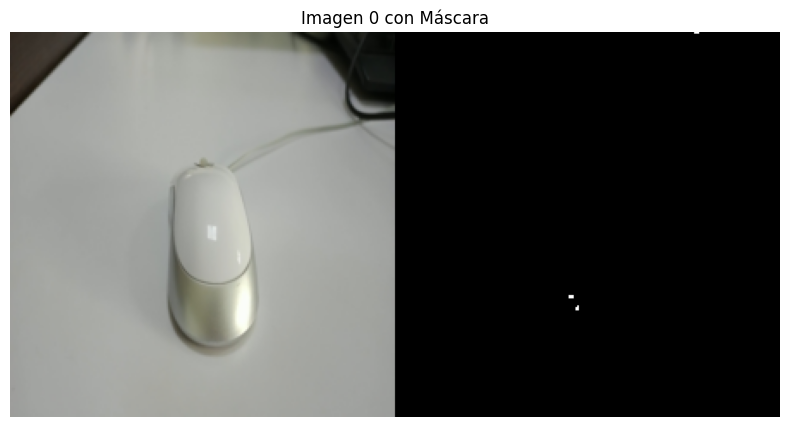

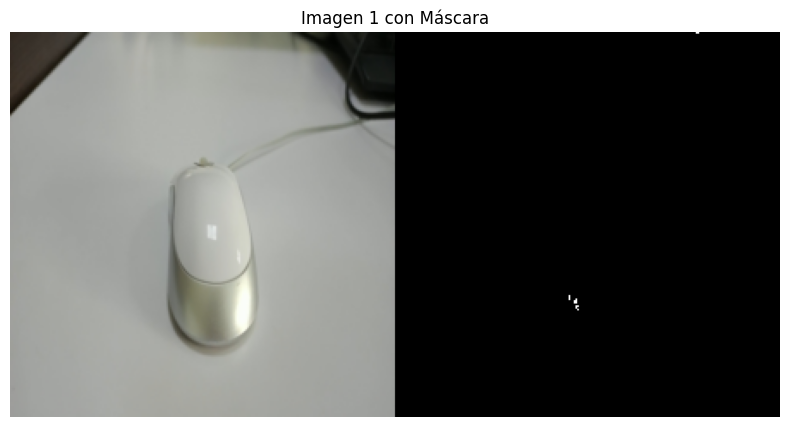

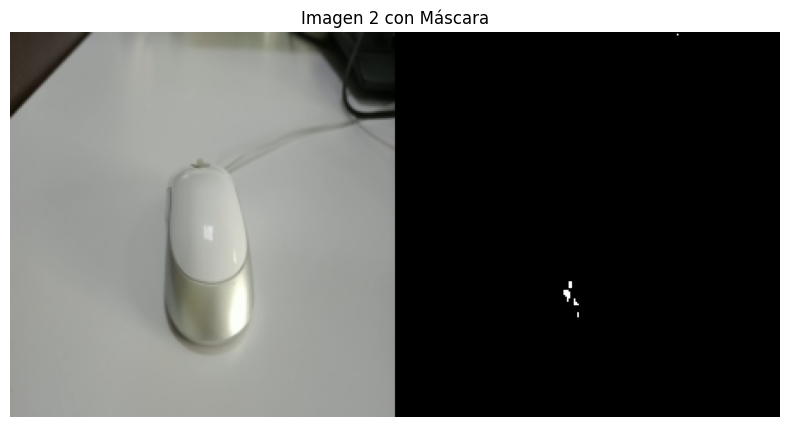

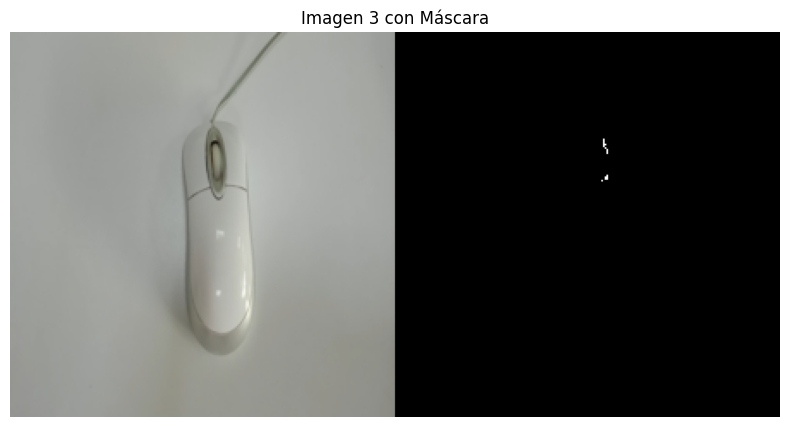

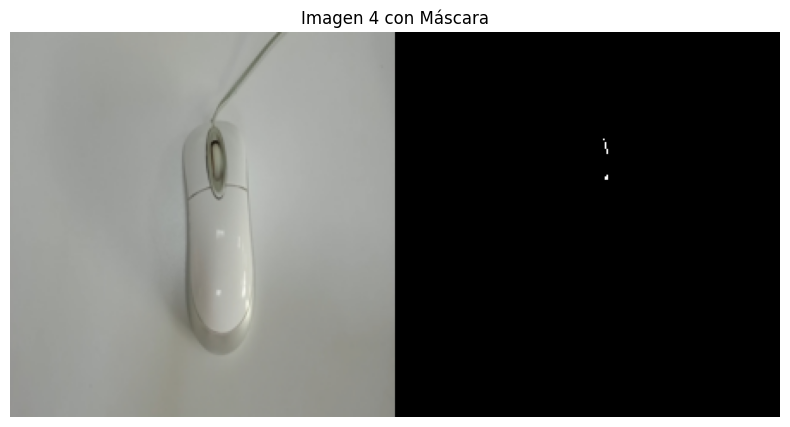

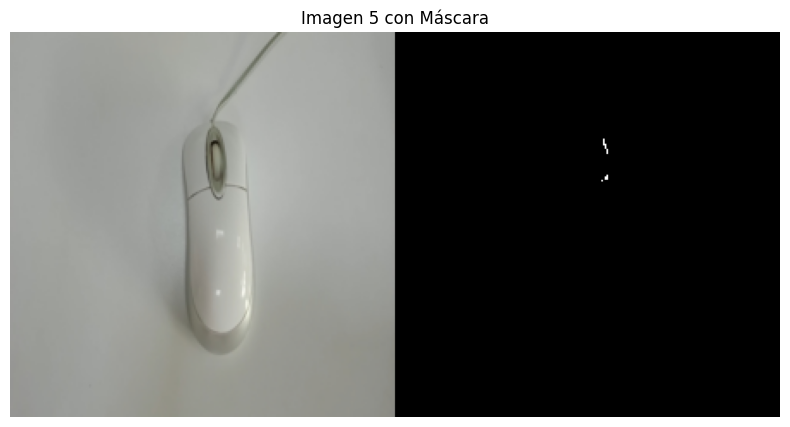

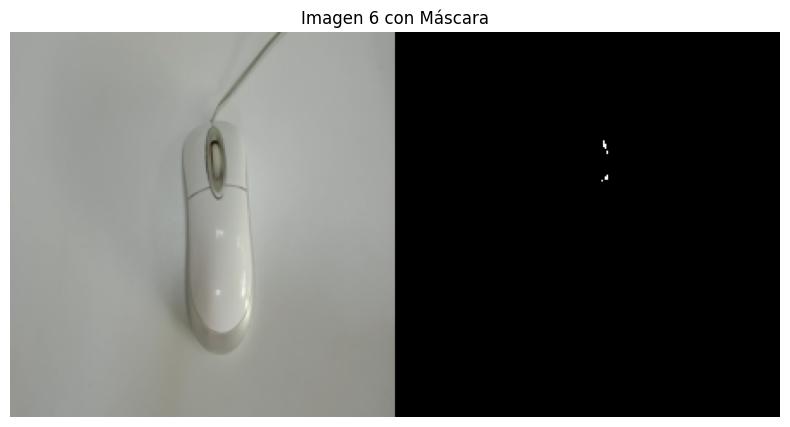

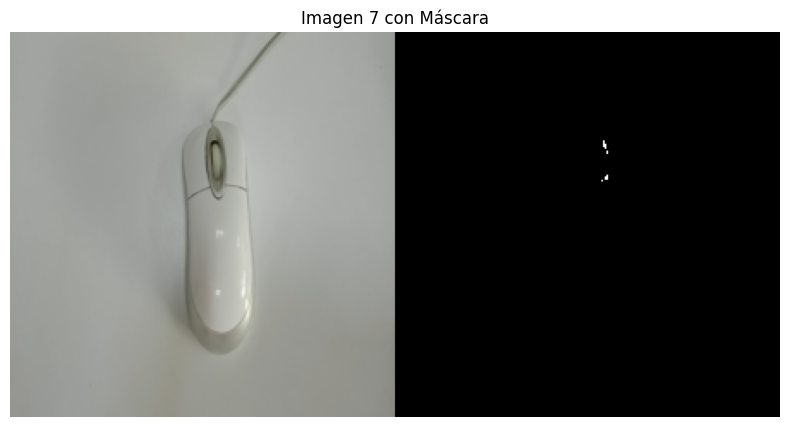

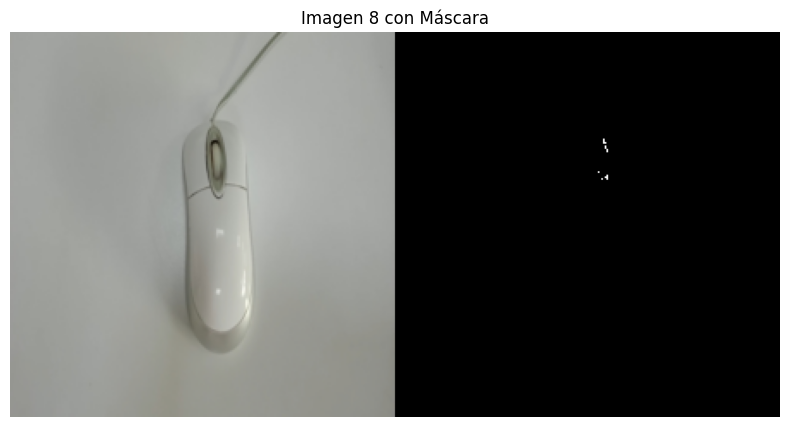

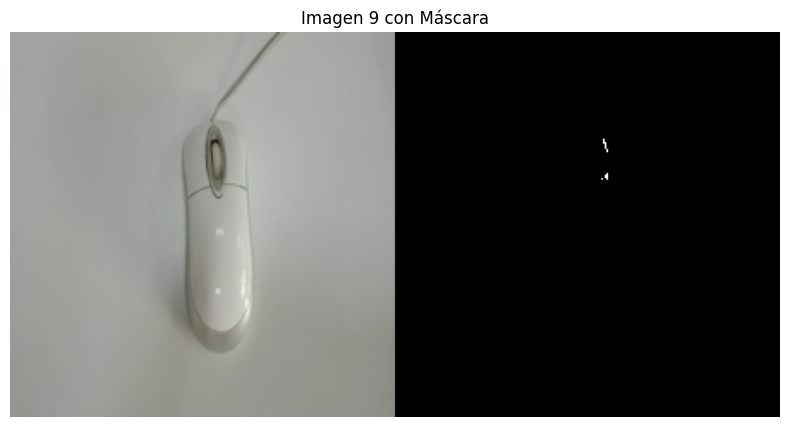

Imágenes con máscaras guardadas en la carpeta 'mascaras'.


In [13]:
import matplotlib.pyplot as plt

# Crear carpeta para guardar las imágenes con máscaras
mask_folder = 'mascaras'
if not os.path.exists(mask_folder):
    os.makedirs(mask_folder)

# Obtener las primeras 10 imágenes del dataset de entrenamiento
for i in range(10):
    image, mask = train_dataset[i]
    
    # Convertir el tensor de imagen y máscara a numpy arrays
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    
    # Guardar la imagen con la máscara
    mask_image = (mask_np > 0.5).astype(np.uint8) * 255  # Convertir la máscara a binaria y escalar a 255
    mask_image = np.stack([mask_image] * 3, axis=-1)  # Convertir a 3 canales
    combined_image = np.concatenate((image_np, mask_image / 255.0), axis=1)  # Combinar imagen y máscara lado a lado
    
    output_path = os.path.join(mask_folder, f"masked_image_{i}.png")
    plt.imsave(output_path, combined_image)
    
    # Mostrar la imagen con la máscara
    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image)
    plt.title(f"Imagen {i} con Máscara")
    plt.axis('off')
    plt.show()

print("Imágenes con máscaras guardadas en la carpeta 'mascaras'.")